In [172]:
from PIL import Image
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import HDBSCAN
import seaborn as sns
import re

from skimage import io, color, filters, measure, morphology

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
from torchvision.transforms import Compose, Resize, ToTensor, CenterCrop

from tqdm import tqdm
import json


Found 1 images


  0%|          | 0/1 [00:00<?, ?it/s]

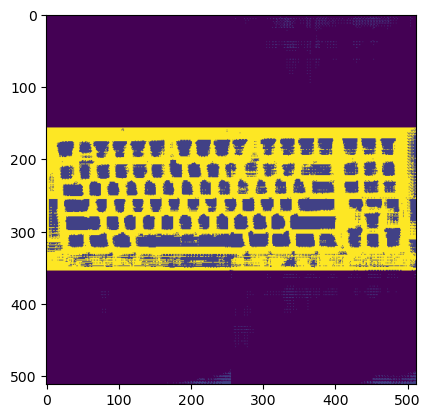

100%|██████████| 1/1 [00:00<00:00, 10.59it/s]

torch.Size([3, 512, 512])


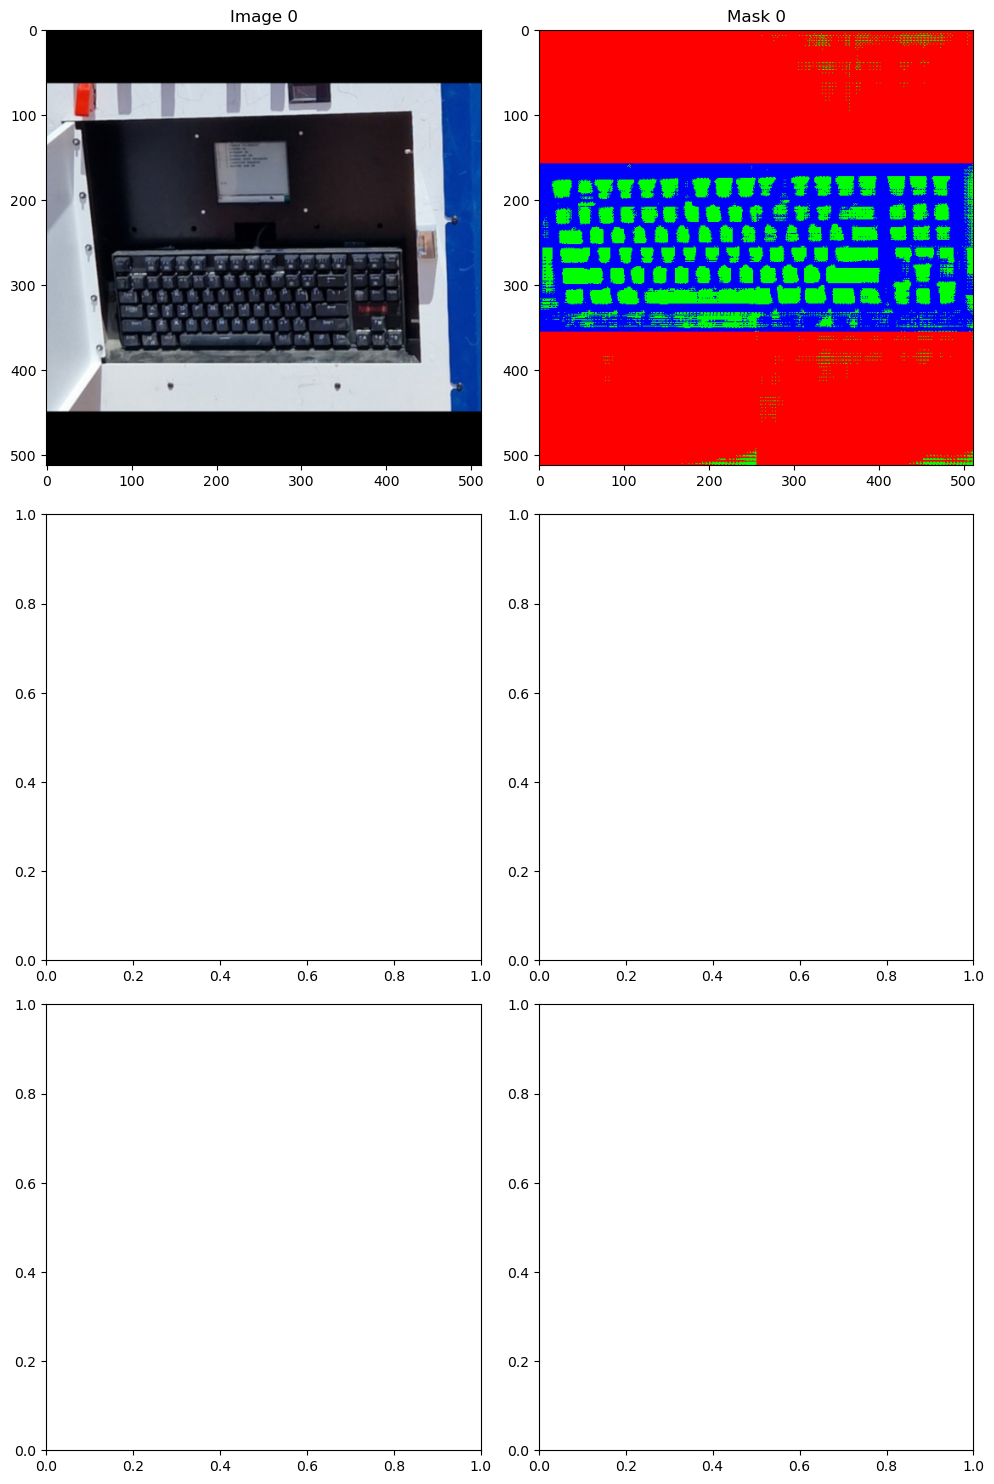

In [173]:
device = "cuda" if torch.cuda.is_available() else "mps" if hasattr(torch.backends, "mps") and torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
IMG_SIZE = 512
img_dir = "../real_testing"

def mask_to_closest_one_hot(mask, unique_values):
    mask_array = np.array(mask, dtype=np.float32)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    mask_tensor = torch.tensor(mask_array).unsqueeze(0)  # Shape: (1, IMAGE_SIZE, IMAGE_SIZE)
    unique_tensor = torch.tensor(unique_values, dtype=torch.float32).view(-1, 1, 1)  # Shape: (3, 1, 1)
    distances = torch.abs(mask_tensor - unique_tensor)  # Shape: (3, IMAGE_SIZE, IMAGE_SIZE)
    closest_indices = torch.argmin(distances, dim=0)  # Shape: (IMAGE_SIZE, IMAGE_SIZE)
    one_hot = torch.nn.functional.one_hot(closest_indices, num_classes=len(unique_values))  # Shape: (IMAGE_SIZE, IMAGE_SIZE, 3)
    one_hot = one_hot.permute(2, 0, 1).float()

    return one_hot

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        all_images = os.listdir(root_dir)
        self.images = [img for img in all_images if re.search("Image", img)]
        print(f"Found {len(self.images)} images")
        self.items = []
        loop = tqdm(self.images)
        for img_path in loop:
            image =  Image.open(os.path.join(self.root_dir, img_path)).convert("RGB")
            mask = Image.open(os.path.join(self.root_dir, self._get_mask_for_image(img_path))).convert("L")
            plt.imshow(mask)
            plt.show()
            if self.transform:
                image = self.transform(image)
            transform2 = Compose([ToTensor()])
            
            image = transform2(image)
            mask0 = np.array(mask)
            unique_values = np.unique(mask0)
            mask = mask_to_closest_one_hot(mask0, unique_values=unique_values)
            mask = mask.numpy()
            self.items.append((image, mask))


    def __len__(self):
        return len(self.images)

    def _get_mask_for_image(self, img):
        return img.replace("Image", "Segmentation")

    def __getitem__(self, idx):
        return self.items[idx]
    
transforms = Compose([
    CenterCrop(1080),
    Resize((IMG_SIZE, IMG_SIZE)),
])

def get_images(image_dir, transform = None, batch_size = 1, shuffle = True, pin_memory = True):
    dataset = ImageDataset(image_dir, transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory)
    return data_loader, data_loader 

train_loader, test_loader = get_images(img_dir, transforms, batch_size=1)

ig, axes = plt.subplots(3, 2, figsize=(10, 15))
masks = []

for i, (img, mask) in enumerate(train_loader):
    axes[i, 0].imshow(img[0].permute(1, 2, 0))
    axes[i, 0].set_title(f'Image {i}')
    axes[i, 1].imshow(mask[0].permute(1, 2, 0))
    axes[i, 1].set_title(f'Mask {i}')
    masks.append(mask.squeeze(0))

print(masks[0].shape)

plt.tight_layout()
plt.show()


39947


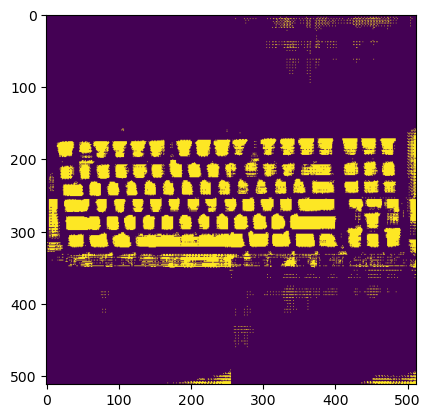

In [174]:
keys = masks[0][1,:].numpy().astype(np.uint8)
plt.imshow(keys)
print(np.sum(keys > 0))

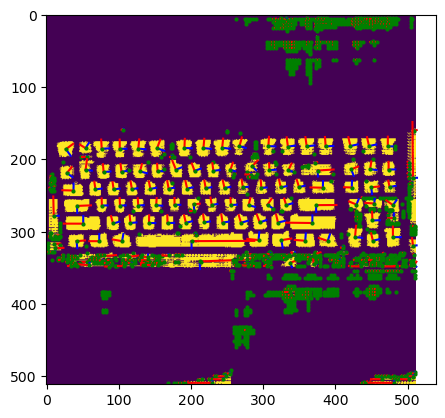

In [175]:
label = measure.label(keys.astype(bool))
regions = measure.regionprops(label)

fig, ax = plt.subplots()
ax.imshow(keys)

centroids = []
for props in regions:
    y0, x0 = props.centroid
    centroids.append(np.array((x0,y0)))
    orientation = props.orientation
    x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=4)
    
plt.show()

# Assume that we see all the keys

1. Find new base

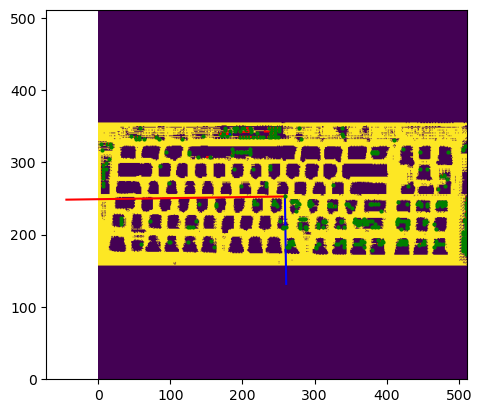

In [176]:
keyboard = masks[0][2,:].numpy().astype(np.uint8)
label = measure.label(keyboard.astype(bool))
regions = measure.regionprops(label)

fig, ax = plt.subplots()
ax.imshow(keyboard)

for props in regions:
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + np.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - np.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - np.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - np.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-b', linewidth=1.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1.5)
    ax.plot(x0, y0, '.g', markersize=4)

ax.invert_yaxis()

plt.show()

(-165.38256217076122, 256.1822100705134) (-333.3825621707612, 64.18221007051343) (177.11743782923878, 42.182210070513435)
[(168.0, 191.99999999999997), (-342.5, 213.99999999999997)]
[array([1, 0]), array([0, 1])] [array([168., 192.]), array([-342.5,  214. ])]
(1590, 1590) (2,) (2, 2) 1.0000000000000004


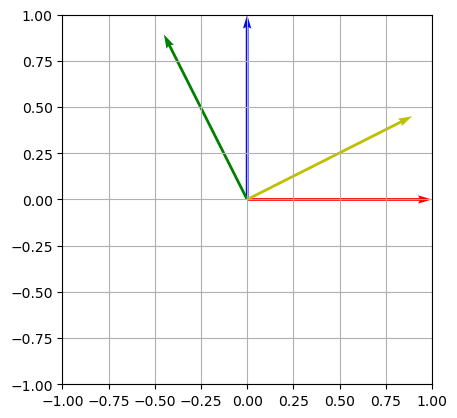

In [177]:
centroids = np.array(centroids) - np.mean(centroids, axis=0)

x_coords = np.array(centroids[:,0]).flatten()
y_coords = np.array(centroids[:,1]).flatten()

y0, x0 = y_coords[np.argmax(y_coords)], x_coords[np.argmax(y_coords)]
y1, x1 = y_coords[np.argmin(x_coords)], x_coords[np.argmin(x_coords)]
y2, x2 = y_coords[np.argmax(x_coords)], x_coords[np.argmax(x_coords)]

print((x0,y0), (x1,y1), (x2, y2))

base1 = [(1,0),(0,1)]
base2 = [ (x0 - x1, y0-y1), (x0-x2, y0-y2)]
print(base2)

base1 = [np.array(vec) for vec in base1]
base2 = [np.array(vec) for vec in base2]
base2 = [vec for vec in base2]
print(base1, base2)

U,S, VT = np.linalg.svd(centroids)
print(U.shape ,S.shape ,VT.shape, np.linalg.det(VT))

not_swap = np.linalg.det(VT) < 0
base2 = VT if not_swap else [[VT[0,0], VT[0,1]], [-1*VT[1,0],-1*VT[1,1]]]

fig, ax = plt.subplots()
origin = np.array([[0, 0], [0, 0]])

ax.quiver(*origin, [vec[0] for vec in base1], [vec[1] for vec in base1], color=['r', 'b'], scale=1, scale_units='xy', angles='xy')

ax.quiver(*origin, [vec[0] for vec in base2], [vec[1] for vec in base2], color=['g', 'y'], scale=1, scale_units='xy', angles='xy')

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')
plt.grid()
plt.show()

In [178]:
M_base1_base2 = np.matrix(base2)

centroids2 = np.matrix(centroids)

centroids_base2 = np.matmul(centroids2, M_base1_base2).T

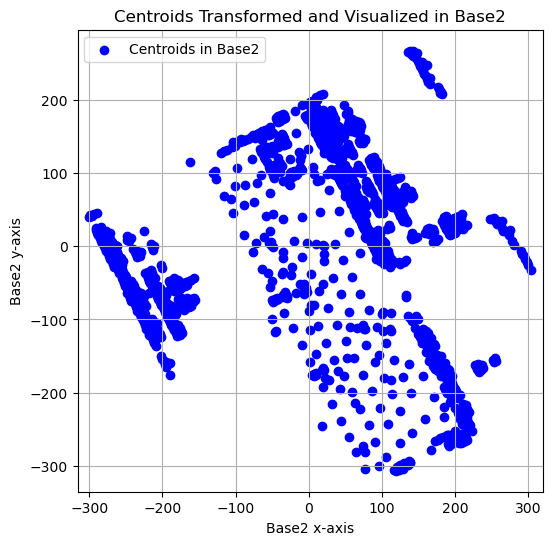

In [179]:
# Normalize centroids to have a length of one
centroids_norm = centroids_base2 #/ np.linalg.norm(centroids_base2, axis=1, keepdims=True)
centroids_norm = centroids_norm

x_coords = np.array(centroids_norm[0, :]).flatten()
y_coords = np.array(centroids_norm[1, :]).flatten()

#y0, x0 = y_coords[np.argmax(y_coords)], x_coords[np.argmax(y_coords)]
#y1, x1 = y_coords[np.argmin(x_coords)], x_coords[np.argmin(x_coords)]
#y2, x2 = y_coords[np.argmax(x_coords)], x_coords[np.argmax(x_coords)]
#
#base2 = [(x0-x2, y0-y2), (x0-x1, y0-y1)]
#base2 = sorted(base2, key= lambda v : np.linalg.norm(v), reverse=True)
#
#M_base1_base2 = np.matrix(base2).T 
#print(M_base1_base2)
#centroids2 = np.matrix(centroids_norm)
#centroids_base2 = np.matmul(np.linalg.inv(M_base1_base2), centroids2)
#
#x_coords = np.array(centroids_base2[:, 0]).flatten()
#y_coords = np.array(centroids_base2[:, 1]).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Centroids in Base2')

# Plot base 2 vectors
#origin = np.array([[0, 0], [0, 0]])  # origin point
#plt.quiver(*origin, base2[:, 0], base2[:, 1], color=['r', 'g'], scale=4, scale_units='xy', angles='xy')

plt.title('Centroids Transformed and Visualized in Base2')
plt.xlabel('Base2 x-axis')
plt.ylabel('Base2 y-axis')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

In [180]:
lr = LinearRegression(fit_intercept=False)
lr.fit(x_coords.reshape(-1,1), y_coords)
print(lr.coef_)

[1.62105413e-16]


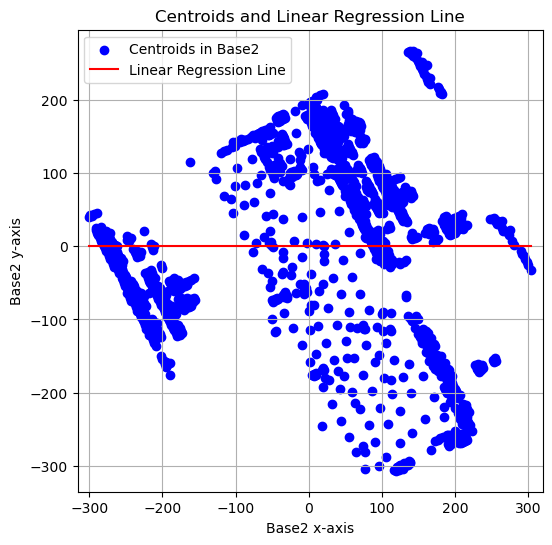

In [181]:
plt.figure(figsize=(6, 6))
plt.scatter(x_coords, y_coords, color='blue', label='Centroids in Base2')

# Plot the linear regression line
x_range = np.linspace(x_coords.min(), x_coords.max(), 100)
y_range = lr.coef_[0] * x_range
plt.plot(x_range, y_range, color='red', label='Linear Regression Line')

plt.title('Centroids and Linear Regression Line')
plt.xlabel('Base2 x-axis')
plt.ylabel('Base2 y-axis')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()


# Lets put this together

In [182]:
def get_centroids(keys):
    label = measure.label(keys.astype(bool))
    regions = measure.regionprops(label)

    space_area = 0
    space_coords = None
    centroids = []
    for i, props in enumerate(regions):
        y0, x0 = props.centroid
        centroids.append(np.array((x0,y0)))

        if props.area > space_area:
            space_area = props.area
            space_coords = i

    return np.array(centroids) if len(centroids) >= 87 else np.array([np.array((0,0))]), space_coords

def get_bases(centroids):
    centroids = np.array(centroids) - np.mean(centroids, axis=0)
    x_coords = np.array(centroids[:,0]).flatten()
    y_coords = np.array(centroids[:,1]).flatten()
    print(np.mean(x_coords), np.mean(y_coords))

    #y0, x0 = y_coords[np.argmax(y_coords)], x_coords[np.argmax(y_coords)]
    #y1, x1 = y_coords[np.argmin(x_coords)], x_coords[np.argmin(x_coords)]
    #y2, x2 = y_coords[np.argmax(x_coords)], x_coords[np.argmax(x_coords)]

    #print((x0,y0), (x1,y1), (x2, y2))

    base1 = [(1,0),(0,1)]
    #base2 = [(x0-x2, y0-y2), (x0-x1, y0-y1)]

    #base2 = sorted(base2, key= lambda v : np.linalg.norm(v), reverse=True)

    U,S, VT = np.linalg.svd(centroids)
    print(U.shape ,S.shape ,VT.shape)
    print(S)
    print(np.linalg.det(VT))

    base2 = VT 
    
    if min([np.linalg.norm(v) for v in base2]) < 1e-6: 
        print("Singular")
        return base1, base1 #error handling
    
    not_swap = np.linalg.det(VT) < 0
    base2 = VT if not_swap else [[VT[0,0], VT[0,1]], [-1*VT[1,0],-1*VT[1,1]]]
    print("Changed:",np.linalg.det(np.matrix(base2)))
    base1 = [np.array(vec) for vec in base1]
    base2 = [np.array(vec) for vec in base2]
    base2 = [vec for vec in base2]

    print(base2)

    return base1, base2

def get_coords(mask):
    keys = mask[2,:].numpy().astype(np.uint8)
    keyboard = mask[1,:].numpy().astype(np.uint8)
    
    centroids, space_coords = get_centroids(keys)
    base1, base2 = get_bases(centroids)

    M_base1_base2 = np.matrix(base2)
    centroids2 = np.matrix(np.array(centroids) - np.mean(centroids, axis=0))
    centroids_base2 = np.matmul(centroids2, M_base1_base2).T

    return centroids, centroids_base2, space_coords, base2

In [183]:
keyboard_layout = [
    ["Esc", "F1", "F2", "F3", "F4", "F5", "F6", "F7", "F8", "F9", "F10", "F11", "F12", "PrtScr", "ScrLck", "Pause"],
    ["`~", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", "-", "=", "Backspace", "Insert", "Home", "PageUp"],
    ["Tab", "Q", "W", "E", "R", "T", "Y", "U", "I", "O", "P", "[", "]", "\\", "Delete", "End", "PageDown"],
    ["Caps Lock", "A", "S", "D", "F", "G", "H", "J", "K", "L", ";", "'", "Enter"],
    ["Shift1", "Z", "X", "C", "V", "B", "N", "M", ",", ".", "/", "Shift", "↑"],
    ["Ctrl1", "Win1", "Alt1", "Spacebar", "Alt", "Win", "Menu", "Ctrl", "←", "↓", "→"],
    #["Insert", "Home", "Page Up", "Delete", "End", "Page Down", "↑", "←", "↓", "→"]
]

In [184]:
for row in keyboard_layout:
    print(len(row))

16
17
17
13
13
11


################
1.4513213326163747e-14 -3.870190220310333e-14
(376, 376) (2,) (2, 2)
[2746.54262896  909.99938137]
1.0
Changed: -1.0
[array([ 0.97464549, -0.22375473]), array([-0.22375473, -0.97464549])]
Space: -56.88244406187382 -11.409473075791421


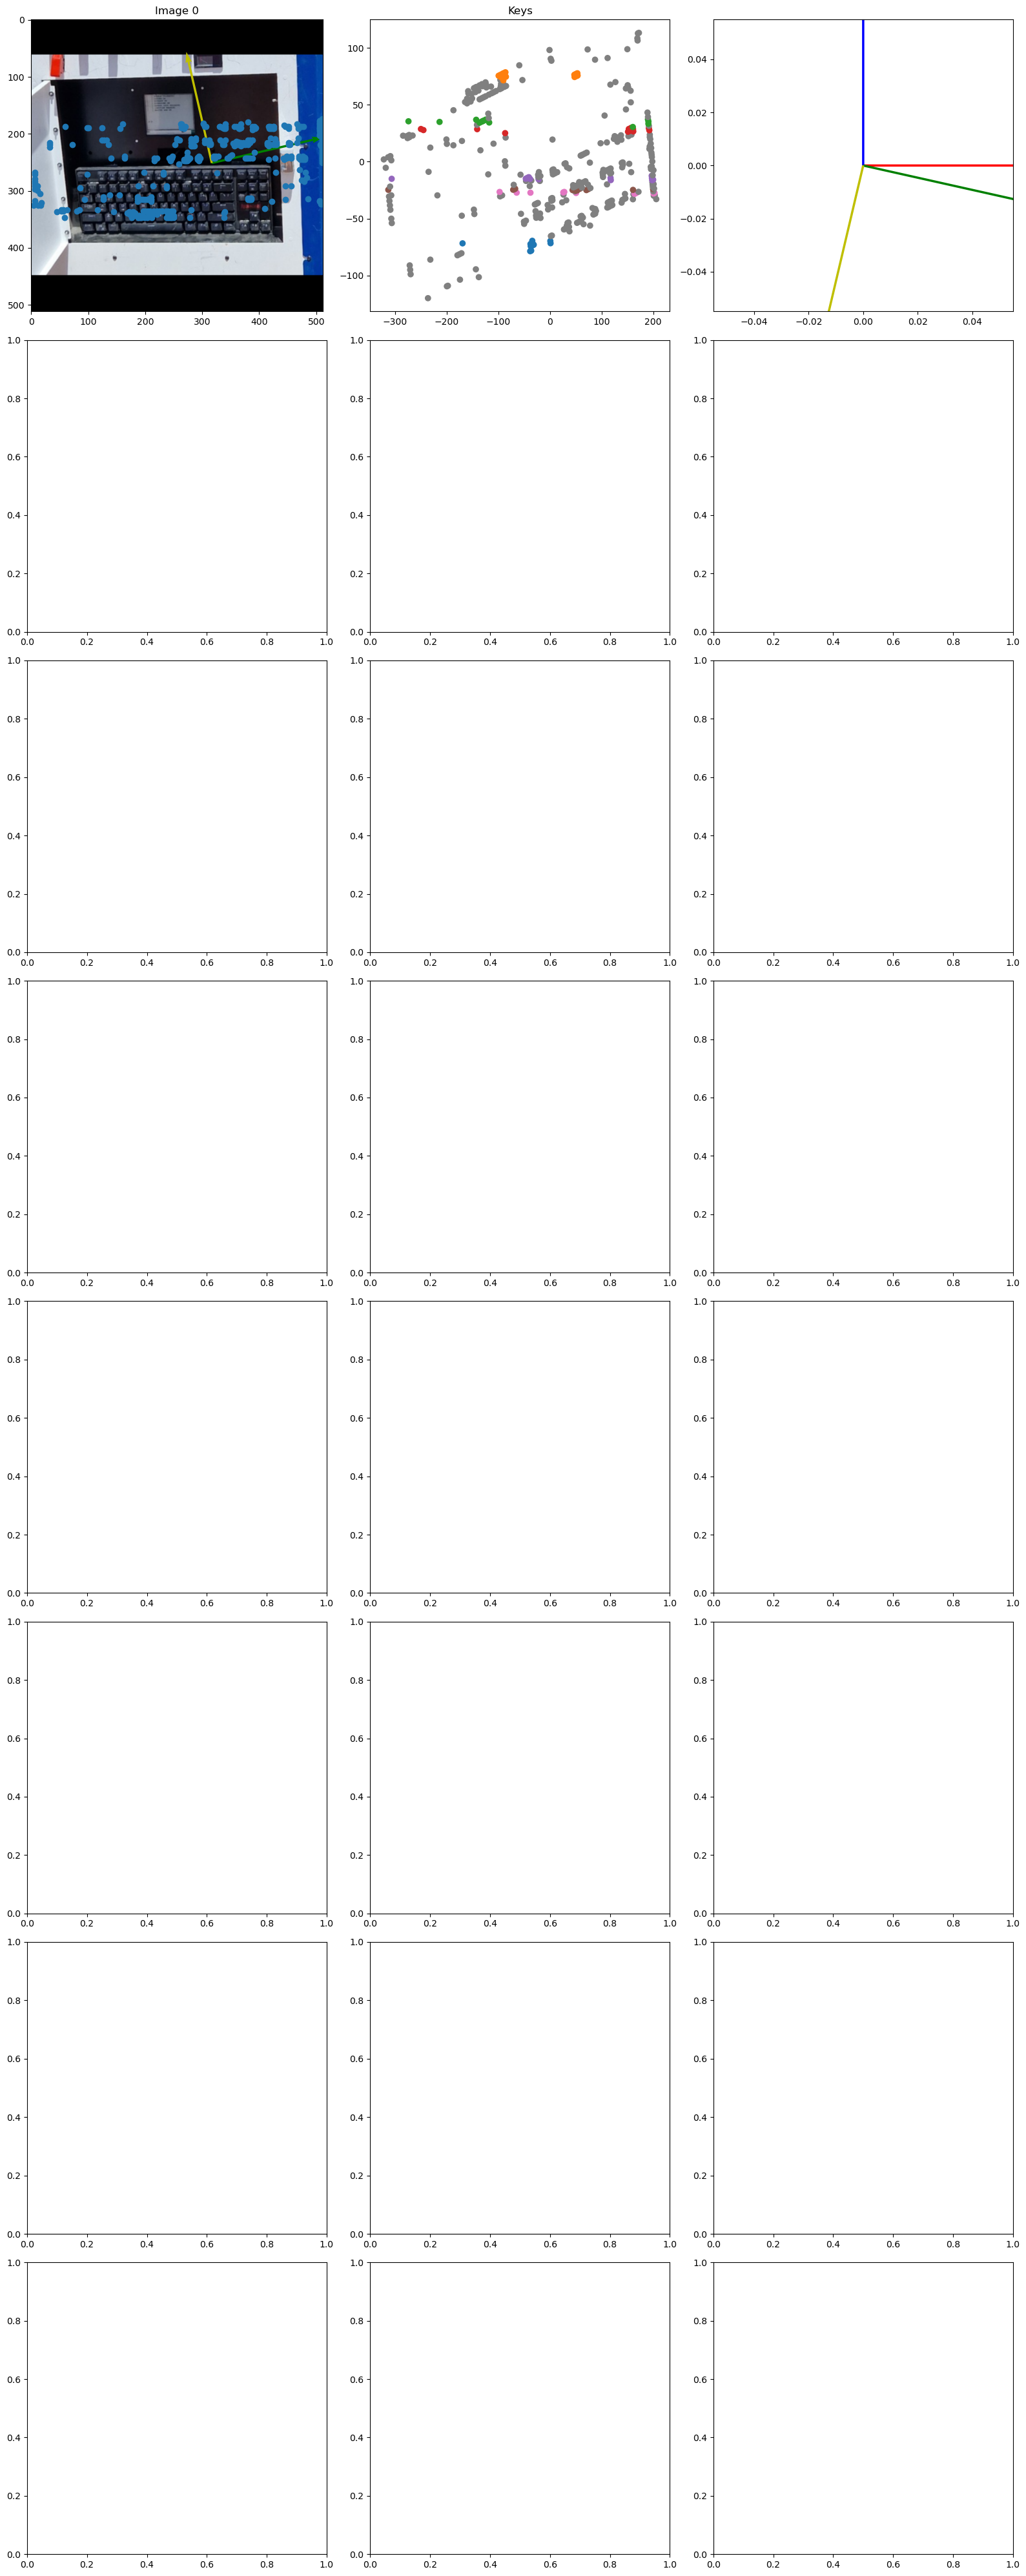

In [185]:
ig, axes = plt.subplots(8, 3, figsize=(16, 40))

for i, (img, mask) in enumerate(train_loader):
    indices = [i for i in range(len(img))]
    for j, idx in enumerate(indices):
        print("################")
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')

        keys, centroids, space_coords, base2 = get_coords(mask[idx])
        x_coords = -np.array(centroids[0, :]).flatten()
        y_coords = -np.array(centroids[1, :]).flatten()

        # Plot base2 vectors with length 200 in the middle of the keyboard
        middle_x, middle_y = np.mean(keys[:, 0]), np.mean(keys[:, 1])
        axes[j, 0].quiver([middle_x, middle_x], [middle_y, middle_y], [200*vec[0] for vec in base2], [200*vec[1] for vec in base2], 
                  color=['g', 'y'], scale=1, scale_units='xy', angles='xy')

        origin = np.array([[0, 0], [0, 0]])
        axes[j,2].quiver(*origin, [vec[0] for vec in base1], [vec[1] for vec in base1], color=['r', 'b'], scale=1, scale_units='xy', angles='xy')
        axes[j,2].quiver(*origin, [vec[0] for vec in base2], [vec[1] for vec in base2], color=['g', 'y'], scale=1, scale_units='xy', angles='xy')

        colors = None
        X = None
        symbols = None
        x_values = None
        y_values = None
        og_x = None
        og_y = None

        if len(x_coords) > 1:
            
            #x_coords = (x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))
            #y_coords = (y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))

            if space_coords is not None:
                space_x = x_coords[space_coords]
                space_y = y_coords[space_coords]
                
                if space_x > 0.5:
                    x_coords = -x_coords
                    #x_coords = (x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))
                if space_y > 0.5:
                    y_coords = -y_coords
                    #y_coords = (y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))

                space_x = x_coords[space_coords]
                space_y = y_coords[space_coords]
                print("Space:", space_x, space_y)

            X = pd.DataFrame({"0": x_coords, "1":y_coords})
            X["1"] = X["1"]*10000

            m = HDBSCAN(min_cluster_size=11, max_cluster_size=17)
            m.fit(X)

            labels = m.labels_

            unique_labels = np.unique(labels)
            palette = sns.color_palette('tab10', n_colors=len(unique_labels))
            palette.append((0.5, 0.5, 0.5))

            colors = [palette[label] if label >= 0 else palette[-1] for label in labels]

            X["rows"] = labels
            X["og0"], X["og1"] = keys[:, 0].flatten(), keys[:, 1].flatten()

            mean_values = X.groupby("rows")["1"].mean()
            sorted_classes = mean_values.sort_values(ascending=False).index
            class_mapping = {old: new for new, old in enumerate(sorted_classes)}
            X["rows_sorted"] = X["rows"].map(class_mapping)
            X["1"] = X["1"]/10000

            if len(unique_labels) == 6:
                letters_dict = {}
                og_letters = {}
                try:
                    for row_number in X["rows_sorted"].unique():

                        row = X[X["rows_sorted"] == row_number]
                        row = row.sort_values(by="0", ascending=True)
                            
                        for key, (_, center) in enumerate(row.iterrows()):
                            letters_dict[keyboard_layout[row_number][key]] = center[["0", "1"]].values.tolist()
                            og_letters[keyboard_layout[row_number][key]] = center[["og0", "og1"]].values.tolist()
                    symbols = list(letters_dict.keys())
                    values = list(letters_dict.values())
                    og_values = list(og_letters.values())

                    x_values = [val[0] for val in values]
                    y_values = [val[1] for val in values]

                    og_x = [val[0] for val in og_values]
                    og_y = [val[1] for val in og_values]
                except Exception as e:
                    print(e)

        axes[j,0].scatter(keys[:, 0].flatten(), keys[:, 1].flatten())
        
        axes[j, 1].scatter(x_coords, y_coords, 
                           color='blue' if colors is None else colors, 
                           label='Centroids in Base2')
        axes[j, 1].set_title(f'Keys')

        if symbols is not None:
            found_letters = {}
            for i, key in enumerate(symbols):
               axes[j, 1].text(x_values[i], y_values[i], key, ha='center', va='center', fontweight='bold', fontsize=12)
               axes[j,0].text(og_x[i], og_y[i], key, ha='center', va='center', fontweight='bold', fontsize=5)
               found_letters[key] = [x_values[i], y_values[i]]
            
            with open(f'found_letters_{j}.json', 'w') as f:
                json.dump(found_letters, f)

    break

plt.tight_layout()
plt.show()

In [186]:
with open(f'found_letters_1.json', 'r') as f:
    found_letters = json.load(f)
    coords = np.array(list(found_letters.values()))
    coords[:,0] = (coords[:,0] - np.min(coords[:,0]))/(np.max(coords[:,0])- np.min(coords[:,0]))
    coords[:,1] = (coords[:,1] - np.min(coords[:,1]))/(np.max(coords[:,1]) - np.min(coords[:,1]))
    found_letters = {key: list(coords[i,:]) for i, key in enumerate(found_letters.keys())}
    print(found_letters)

with open(f'clean_letters.json', 'w') as f:
    json.dump(found_letters, f)

FileNotFoundError: [Errno 2] No such file or directory: 'found_letters_1.json'

# Solution

In [ ]:
from key_finder import KeyFinder
from image_reader import get_images

train_loader, test_loader = get_images()
for i, (img, mask) in enumerate(train_loader):
    break

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Found 520 images


100%|██████████| 520/520 [01:16<00:00,  6.83it/s]


In [ ]:
import numpy as np
keys = mask[0][2,:].numpy().astype(np.uint8)

In [ ]:
kf = KeyFinder()

In [ ]:
letters = kf.find(keys)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(83, 2)


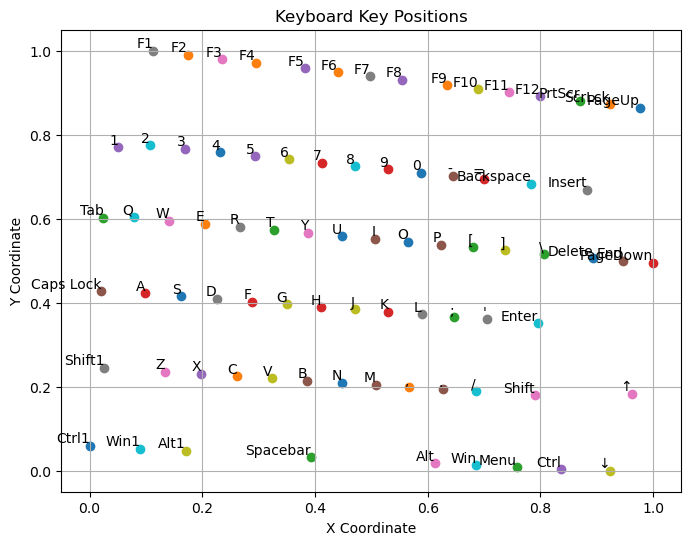

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

# Iterate through the dictionary and plot each key's position
for key, value in letters.items():
    x, y = value['coords'][0,0], value['coords'][0,1]   # Extract coordinates
    plt.scatter(x, y, label=key)  # Plot point
    plt.text(x, y, key, fontsize=10, ha='right', va='bottom')  # Add label

# Formatting
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Keyboard Key Positions")
plt.grid(True)
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(87, 2)
Rotate 0 : 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(87, 2)
Rotate 1 : 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
(87, 2)
Rotate 2 : 1
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require In

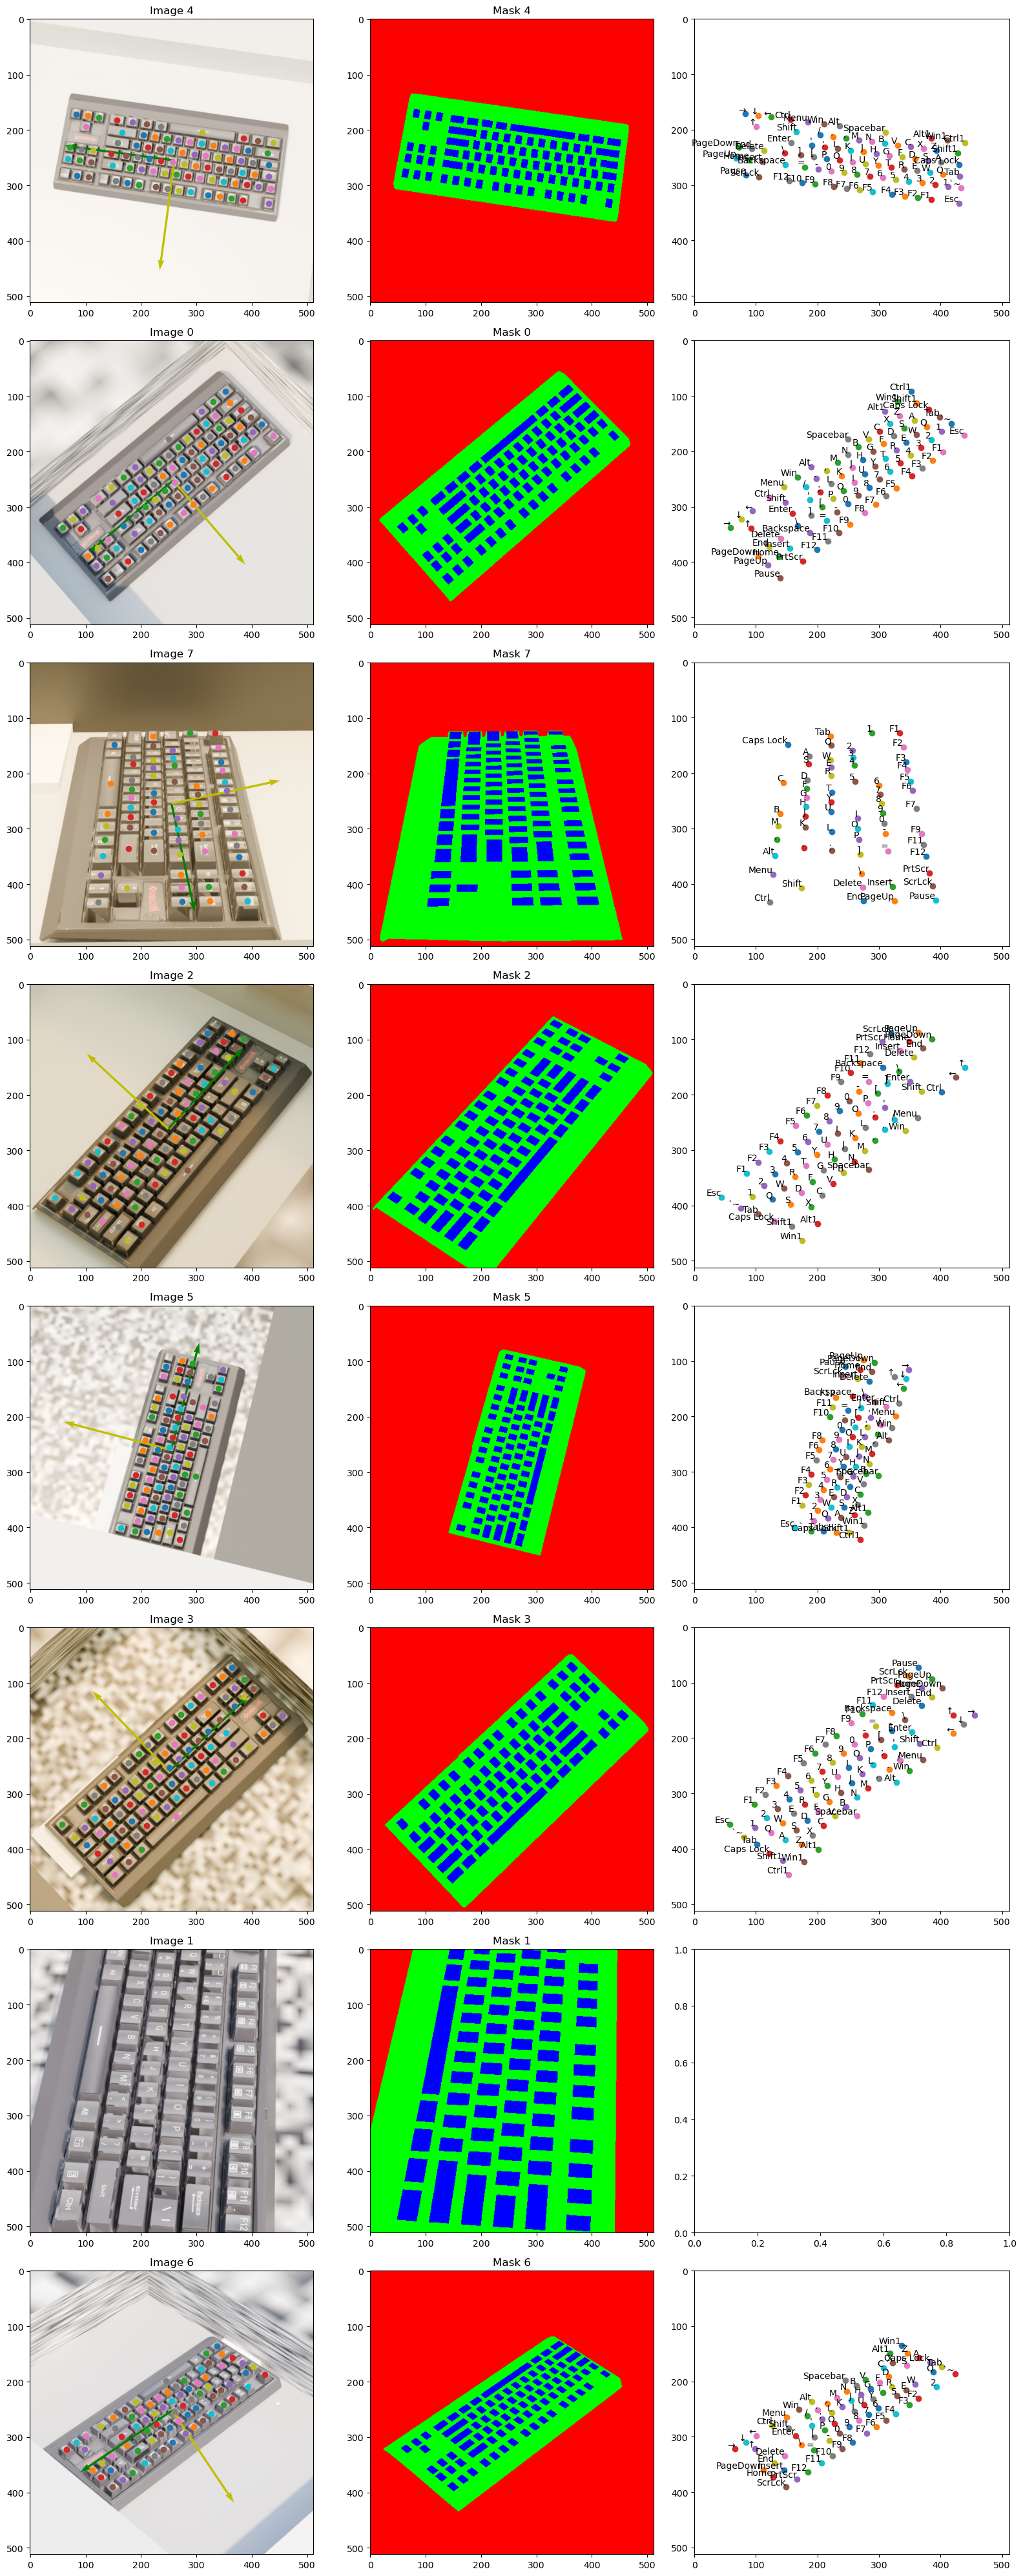

In [ ]:
fig, axes = plt.subplots(8, 3, figsize=(16, 40))

for i, (img, mask) in enumerate(train_loader):
    indices = np.random.choice(img.size(0), 8, replace=False)
    for j, idx in enumerate(indices):
        axes[j, 0].imshow(img[idx].permute(1, 2, 0))
        axes[j, 0].set_title(f'Image {idx}')
        axes[j, 1].imshow(mask[idx].permute(1, 2, 0))
        axes[j, 1].set_title(f'Mask {idx}')
        keys = mask[idx][2,:].numpy().astype(np.uint8)
        noise = np.zeros_like(keys)
        ones_indices = np.random.choice(np.arange(keys.size), size=5, replace=False)
        noise.flat[ones_indices] = 1
        keys = keys + noise
        try:
            kf = KeyFinder()
            letters = kf.find(keys)
            middle_x, middle_y = np.mean(kf.centers[:, 0]), np.mean(kf.centers[:, 1])
            axes[j, 0].quiver([middle_x, middle_x], 
                              [middle_y, middle_y], 
                              [200*vec[0] for vec in kf.base2], 
                              [200*vec[1] for vec in kf.base2], 
                              color=['g', 'y'], scale=1, scale_units='xy', angles='xy')
        except Exception as e:
            continue

        rotate = 1
        for key, value in letters.items():
            x, y = value['coords'][0,0], value['coords'][0,1] 
            x = x*(kf.return_values[1] - kf.return_values[0]) + kf.return_values[0] 
            y = y*(kf.return_values[3] - kf.return_values[2]) + kf.return_values[2] 
            coords = np.matrix([x,y])
            inverse = np.transpose(np.matrix(kf.base2))
            coords = np.matmul(coords, inverse)
            
            x = coords[0,0] + np.mean(kf.centers[:,0])
            y = coords[0,1] + np.mean(kf.centers[:,1])
            x = x+ int(x<0)*512
            y = y+ int(y<0)*512
            
            axes[j,2].scatter(x, y, label=key)  # Plot point
            axes[j,0].scatter(x, y, label=key)  # Plot point
            axes[j,2].text(x, y, key, fontsize=10, ha='right', va='bottom')
            axes[j,2].set_xlim([0,512])
            axes[j,2].set_ylim([0,512])
            axes[j,2].invert_yaxis()
        print("Rotate",j,":", rotate)
    break

plt.tight_layout()
plt.show()